# Evaluate summaries

Lets evaluate the quality of the resulting summaries.


## Choosing an appropriate metric

We will consider first, [ROUGE](https://en.wikipedia.org/wiki/ROUGE_(metric)), which measures the number of overlapping textual units (n-grams) between the summary and the reference. 

Install it with the `install_rouge.sh` script, as it involves a few steps.

Let's create some sample summaries to gain an intuition of this metric.

In [8]:
# Extracted from https://en.wikipedia.org/wiki/Automatic_summarization
reference_text = """Automatic summarization is the process of shortening a set of data computationally,
to create a subset (a summary) that represents the most important or relevant information within the original content.
Artificial intelligence algorithms are commonly developed and employed to achieve this, specialized for different types of data.
"""


summary_A = "Automatic summarization consists of turning longer input data into a shorter subset, keeping the most important parts"
summary_B = "Automatic summarization is the process of shortening data computationally into a subset of most relevant information"
summary_C = "Automatic summarization computationally relevant Artificial intelligence specialized data"

summaries = [summary_A, summary_B, summary_C]


We need to write the texts to file to calculate the ROUGE metric.

In [9]:
with open(f"./metrics/sample/system.001.txt", "w+") as system:
    system.write(reference_text)

letters = ["A", "B", "C"]
for index, summary in enumerate(summaries):
    with open(f"./metrics/sample/model.{letters[index]}.001.txt", "w+") as model:
        model.write(summary)

In [10]:
from pyrouge import Rouge155

def get_rouge_l_f(model):
    r = Rouge155()
    r.system_dir = "./metrics/sample/"
    r.model_dir = "./metrics/sample/"
    r.system_filename_pattern = "system.(\d+).txt"
    r.model_filename_pattern = f"model.{model}.#ID#.txt"

    output = r.convert_and_evaluate()
    return r.output_to_dict(output)["rouge_l_f_score"]

In [11]:
print(f"Rouge-L(F) A: {get_rouge_l_f('A')}")
print(f"Rouge-L(F) B: {get_rouge_l_f('B')}")
print(f"Rouge-L(F) C: {get_rouge_l_f('C')}")

2024-04-11 14:03:06,320 [MainThread  ] [INFO ]  Writing summaries.
2024-04-11 14:03:06,324 [MainThread  ] [INFO ]  Processing summaries. Saving system files to /tmp/tmpzhg8lk99/system and model files to /tmp/tmpzhg8lk99/model.
2024-04-11 14:03:06,325 [MainThread  ] [INFO ]  Processing files in ./metrics/sample/.
2024-04-11 14:03:06,325 [MainThread  ] [INFO ]  Processing system.001.txt.
2024-04-11 14:03:06,326 [MainThread  ] [INFO ]  Processing model.B.001.txt.
2024-04-11 14:03:06,327 [MainThread  ] [INFO ]  Processing model.C.001.txt.
2024-04-11 14:03:06,328 [MainThread  ] [INFO ]  Processing model.A.001.txt.
2024-04-11 14:03:06,328 [MainThread  ] [INFO ]  Saved processed files to /tmp/tmpzhg8lk99/system.
2024-04-11 14:03:06,329 [MainThread  ] [INFO ]  Processing files in ./metrics/sample/.
2024-04-11 14:03:06,329 [MainThread  ] [INFO ]  Processing system.001.txt.
2024-04-11 14:03:06,330 [MainThread  ] [INFO ]  Processing model.B.001.txt.
2024-04-11 14:03:06,331 [MainThread  ] [INFO ] 

Rouge-L(F) A: 0.28125
Rouge-L(F) B: 0.44444
Rouge-L(F) C: 0.29091


We can observe a clear limitation of lexical overlap metrics, such as ROUGE: summary C, which was not very coherent ranks higher than summary A, which was fully coherent.

Let's try now an example of a semantic overlap metric, [BERTScore](https://github.com/Tiiiger/bert_score), an automatic evaluation metric from Zhang et. al (2020):
> BERTScore leverages the pre-trained contextual embeddings from BERT and matches words in candidate and reference sentences by cosine similarity. It has been shown to correlate with human judgment on sentence-level and system-level evaluation.

We are dealing with relatively long texts but BERT and related models can"t process them. As per the BERTScore authors:
> Because BERT, RoBERTa, and XLM with learned positional embeddings are pre-trained on sentences with max length 512, BERTScore is undefined between sentences longer than 510 (512 after adding [CLS] and [SEP] tokens). The sentences longer than this will be truncated. Please consider using XLNet which can support much longer inputs.

Here is a description of the XLNet model from the [Hugging Face model card](https://huggingface.co/xlnet/xlnet-large-cased) (**emphasis** mine):
> XLNet is a new unsupervised language representation learning method based on a novel generalized permutation language modeling objective. Additionally, XLNet employs Transformer-XL as the backbone model, **exhibiting excellent performance for language tasks involving long context**. Overall, XLNet achieves state-of-the-art (SOTA) results on various downstream language tasks including question answering, natural language inference, sentiment analysis, and document ranking.

Next, we will instantiate a `BERTScorer` object, based on the XLNet model. The embedding layer is chosen as per [the authors recommendation](https://docs.google.com/spreadsheets/d/1RKOVpselB98Nnh_EOC4A2BYn8_201tmPODpNWu4w7xI/edit#gid=0).

In [12]:
from bert_score import BERTScorer

scorer = BERTScorer(
    lang="en",
    model_type="xlnet/xlnet-large-cased",
    num_layers=7
)


Let"s start by getting an intuition about the metric. We create some sample summaries.

In [13]:
_, _, F1 = scorer.score(summaries, [reference_text] * len(summaries))

In [14]:
F1

tensor([0.4748, 0.5723, 0.3627])

For a comprehensive study of summarization evaluation, please check [the paper from Fabbri et al](https://arxiv.org/abs/2007.12626).

## Evaluate some sample summaries

Let's try now BERTScore with a couple of our summaries.

In [15]:
import pandas as pd

df_mixtral = pd.read_csv("./summaries/awesome_nature_100_mixtral_8x7b_instruct_summaries.csv")
df_llama2 = pd.read_csv("./summaries/awesome_nature_100_llama2_70b_chat_summaries.csv")

In [16]:
reference_00 = df_mixtral["transcript"][0]
summ_mixtral_00 = df_mixtral["MIXTRAL_8X7B_INSTRUCT_summary"][0]
summ_llama2_00 = df_llama2["LLAMA2_70B_CHAT_summary"][0]

In [17]:
print(reference_00)


Meet Odontochelys semitestacea. This little creature spends its days 
splashing in Late Triassic swamps with a host of other reptiles. Under the surface lies its best 
defense against attack: a hard shell on its belly. Odontochelys is an early ancestor 
of the turtle. Its half-shelled body illustrates an 
important point about the modern turtle: it actually has two shells that develop 
totally separately while the turtle is still an embryo. Both are extensions of the animal’s 
skeleton, and together they are made 
of almost 60 bones. Like other embryos, turtle embryos are made of 
undifferentiated cells that become specific cell types, and then organs and tissues, through gene activity and communication
between cells. At first, turtle embryos look very similar
to those of other reptiles, birds, and mammals, except for a bulge of cells called 
the carapacial ridge. The ridge expands around the body 
between the neck and lower back, creating a disc shape. It guides the formation of the u

In [18]:
print(summ_mixtral_00)

The video explains how turtle shells evolved twice. The first turtle ancestor, Eunotosaurus africanus, had broad, flat ribs that anchored the muscles of its powerful forearms. The second turtle ancestor, Odontochelys semitestacea, had thick ribs and a belly plate for protection. The first fossil evidence of the full shell characteristic of modern turtles is about 210 million years old, and belongs to a species called Proganochelys quenstedti, whose ribs had fused. Modern turtle shells are diverse, with sea turtles having flatter, lighter shells for streamlined gliding through the water, land-dwelling tortoises having domed shells that can slip free of predators’ jaws, and leatherback and softshell turtles having shells without the ring of bone around the edge or the tough scutes covering it.

Curious facts:

* Turtles have two shells that develop separately while the turtle is still an embryo.
* The upper part of the turtle’s shell, called the carapace, is made of fifty bones that grow

In [19]:
print(summ_llama2_00)

The video discusses the evolution of turtle shells, which have two separate shells that develop independently while the turtle is still an embryo. The upper shell, or carapace, is made of 50 bones that form from a bulge of cells called the carapacial ridge. The lower shell, or plastron, is made of nine plate-like bones that are produced by neural crest cells. The shell provides protection for turtles, but also presents challenges for breathing. The video also mentions that the first known turtle ancestor, Eunotosaurus africanus, had broad, flat ribs that anchored the muscles of its powerful forearms.

Curious facts:

* Turtles have two separate shells that develop independently while they are still embryos.
* The upper shell, or carapace, is made of 50 bones that form from a bulge of cells called the carapacial ridge.
* The lower shell, or plastron, is made of nine plate-like bones that are produced by neural crest cells.
* The shell provides protection for turtles, but also presents c

Let's check the word lenghts of each piece:

In [20]:
print(f"Length of reference trasncript (words): {len(reference_00.split())}")
print(f"Length of Mixtral summary (words): {len(summ_mixtral_00.split())}")
print(f"Length of Llama2 summary (words): {len(summ_llama2_00.split())}")

Length of reference trasncript (words): 609
Length of Mixtral summary (words): 303
Length of Llama2 summary (words): 208


We can draw a couple of observations:
* Models produced summaries from roughly 1/2 to 1/3 of the original length
* None of the models was very good at following the instruction to keep the summary in 100 words or less. This is becuase language models in general are not very good at doing math, especially meta-math, or math about the actual generation.

Let's calculate now the BERTScore for these summaries.

In [21]:
_, _, F1 = scorer.score([summ_mixtral_00, summ_llama2_00], [reference_00] * 2)
F1

tensor([0.7944, 0.6852])

Let's do a sanity check to verify if BERTScore with XLNet is actually sensitive to the whole texts.

In [22]:
reference_00 += """this a dummy sentence with some extra-domain terms meant to
lower the score of the summaries: computer, GPU, processor, algorithm
"""

In [23]:
_, _, F1 = scorer.score([summ_mixtral_00, summ_llama2_00], [reference_00] * 2)
F1

tensor([0.7854, 0.6781])

Indeed, the scores were lowered slightly, so this proves that took into account the whole reference text, thanks to XLNet longer context over BERT and variations.

## Calculating a winner

In [24]:
def calculate_winner(scorer, row):
    summary_mixtral = row["MIXTRAL_8X7B_INSTRUCT_summary"]
    summary_llama2 = row["LLAMA2_70B_CHAT_summary"]
    reference = row["transcript"]
    _, _, F1 = scorer.score(
        [summary_mixtral, summary_llama2],
        [reference] * 2
    )
    if F1[0] > F1[1]:
        return "mixtral"
    else:
        return "llama2"

In [25]:
df_all = df_mixtral.assign(LLAMA2_70B_CHAT_summary=df_llama2["LLAMA2_70B_CHAT_summary"])
df_all["winner"] = df_all.apply(lambda x: calculate_winner(scorer, x), axis=1)

Incidentally, let's calculate acceleration of evaluation of GPU vs CPU (the BERTScorer is allocated by default on the GPU, when available).

In [26]:
scorer_cpu = BERTScorer(
    lang="en",
    model_type="xlnet/xlnet-large-cased",
    num_layers=7,
    device="cpu"
)

In [27]:
_ = df_all[:10].apply(lambda x: calculate_winner(scorer_cpu, x), axis=1)

Ten summaries on the CPU take ~25 seconds, which would mean ~250 seconds for the 100 summaries against ~10 seconds with the GPU, so we are achieving a ~25x speedup.

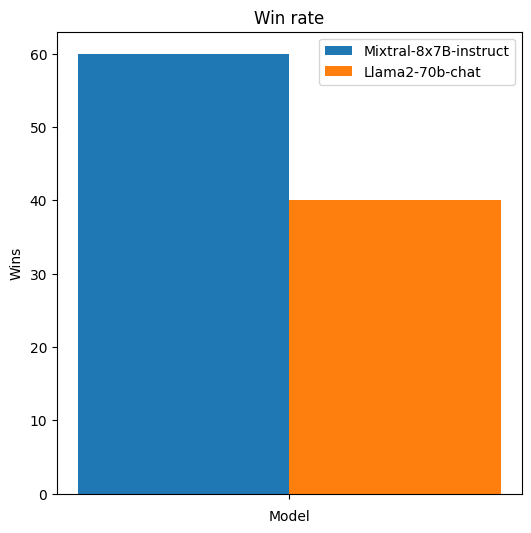

In [28]:
import matplotlib.pyplot as plt

mixtral_won = df_all.loc[df_all["winner"] == "mixtral"].shape[0]
llama2_won = df_all.loc[df_all["winner"] == "llama2"].shape[0]

plt.figure(figsize=(6,6))
plot_index = [0]
index_mixtral = [-0.1]
index_llama2 = [+0.1]
labels = ["Mixtral-8x7B-Instruct", "Llama2-70B-chat"]
plt.bar(index_mixtral, mixtral_won, label='Mixtral-8x7B-instruct', width=0.2)
plt.bar(index_llama2, llama2_won, label='Llama2-70b-chat', width=0.2)
plt.xticks(plot_index, labels=[""])
plt.xlabel('Model')
plt.ylabel('Wins')
plt.title('Win rate')
plt.legend()
plt.show()

Mixtral won in this experiment of summarizing YouTube transcripts with Llama2 close in the win rate. 

To wrap up, let's save the results to file.

In [29]:
df_all.to_csv(f"./summaries/awesome_nature_100_winner_summaries.csv")